# Проект: Прогнозирование открытия депозита

In [272]:
# Импортируем необходимые библиотеки для работы с данными и моделями
import pandas as pd  # для работы с данными в формате DataFrame
import numpy as np  # для работы с массивами данных и математическими операциями

# Для визуализации данных
import matplotlib.pyplot as plt
import seaborn as sns

# Импортируем инструменты для предварительной обработки данных
from sklearn.preprocessing import LabelEncoder  # для преобразования категориальных переменных в числовые
from sklearn import linear_model  # для линейных моделей
from sklearn import ensemble  # для ансамблевых методов, таких как RandomForest, GradientBoosting
from sklearn import metrics  # для оценки качества модели
from sklearn import preprocessing  # для нормализации/масштабирования данных
from sklearn.model_selection import train_test_split, cross_val_score  # для разделения данных на обучающие и тестовые выборки и кросс-валидации
from sklearn.feature_selection import SelectKBest, f_classif  # для выбора лучших признаков на основе статистических тестов

# Отключаем предупреждения, чтобы они не мешали чтению
import warnings
warnings.filterwarnings('ignore')

## Знакомство с данными, обработка пропусков и выбросов

#### Данные о клиентах банка:

- **age** (возраст);
- **job** (сфера занятости);
- **marital** (семейное положение);
- **education** (уровень образования);
- **default** (имеется ли просроченный кредит);
- **housing** (имеется ли кредит на жильё);
- **loan** (имеется ли кредит на личные нужды);
- **balance** (баланс).

#### Данные, связанные с последним контактом в контексте текущей маркетинговой кампании:

- **contact** (тип контакта с клиентом);
- **month** (месяц, в котором был последний контакт);
- **day** (день, в который был последний контакт);
- **duration** (продолжительность контакта в секундах).

#### Прочие признаки:

- **campaign** (количество контактов с этим клиентом в течение текущей кампании);
- **pdays** (количество пропущенных дней с момента последней маркетинговой кампании до контакта в текущей кампании);
- **previous** (количество контактов до текущей кампании)
- **poutcome** (результат прошлой маркетинговой кампании).

#### Целевая переменная:

**deposit** (согласится ли клиент открыть депозит в банке).

In [273]:
df = pd.read_csv('data/bank_fin.csv', sep = ';')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


In [274]:
# Исследуем данные на предмет пропусков.
df.isnull().sum()

age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

In [275]:
# Проверим остальные признаки на пропуски, так как они могут быть обозначены другим словом 
df['job'].value_counts()

job
management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: count, dtype: int64

Видим, что пропуски обозначаются словом "unknown"

In [276]:
# Найдем столбцы, в которых присутствует это слово
cols_with_unkonwn = df.columns[df.isin(['unknown']).any()].tolist()

print(cols_with_unkonwn)

['job', 'education', 'contact', 'poutcome']


In [277]:
# Преобразуем признак balance во float
df['balance'] = df['balance'].apply(lambda x: float(str(x).replace(' ', '').replace(',', '.').replace('$', '')))

# Обработаем пропуски в признаке balance , заменив их на медианные значения
df['balance'] = df['balance'].fillna(df['balance'].median())
# Обработаем пропуски в категориальных признаках: job и education, заменив их на модальные значения
df.loc[df['job'] == 'unknown', 'job'] = df['job'].mode()[0]
df.loc[df['education'] == 'unknown', 'education'] = df['education'].mode()[0]

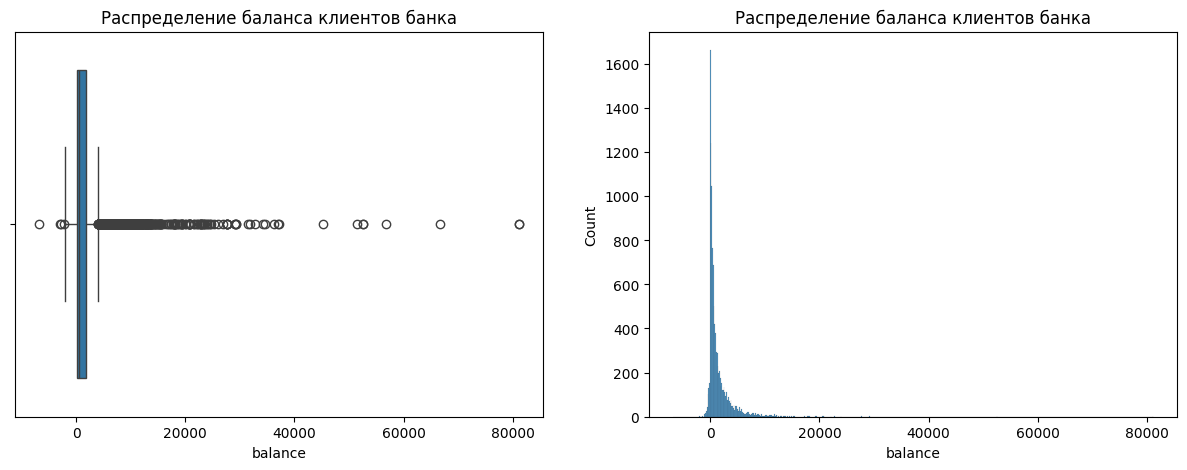

In [278]:
# Найдем выбросы для признака balance, используя метод Тьюки
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
balance_box = sns.boxplot(data=df, x='balance', ax=axes[0])
balance_box.set_title('Распределение баланса клиентов банка');
balance_hist = sns.histplot(data=df, x='balance', ax=axes[1])
balance_hist.set_title('Распределение баланса клиентов банка');

Видим большое количество выбросов, устраним их, используя метод Тьюки

In [279]:
# Избавимся от выбросов, используя метод Тьюки
# Вычислим квартили и IQR
q1 = np.percentile(df['balance'], 25)
q3 = np.percentile(df['balance'], 75)
iqr = q3 - q1

# Вычислим верхний и нижний предел для выбросов
lower_bound = q1 - iqr * 1.5
upper_bound = q3 + iqr * 1.5

# Определим число выбросов
outliers = df[(df['balance'] < lower_bound) | (df['balance'] > upper_bound)]
# Очистим датасет от выбросов
cleaned_df = df[(df['balance'] >= lower_bound) & (df['balance'] <= upper_bound)]

print(f'Число выбросов: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned_df.shape[0]}')

Число выбросов: 1057
Результирующее число записей: 10105


## Разведывательный анализ

deposit
no     5424
yes    4681
Name: count, dtype: int64


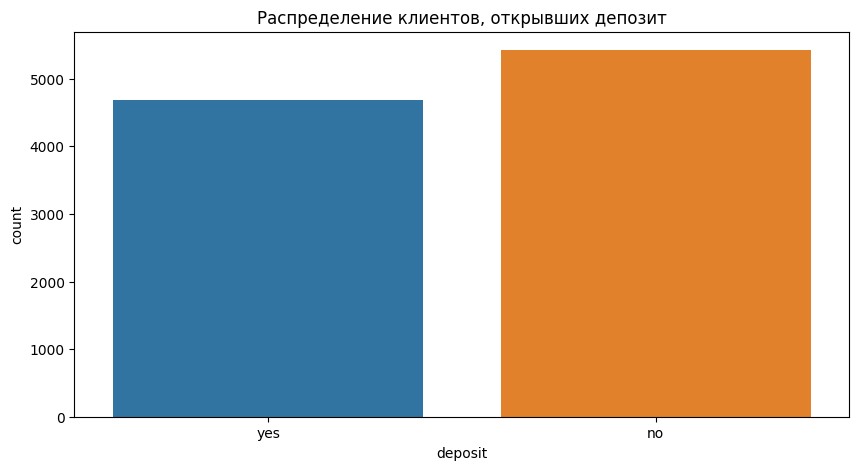

In [280]:
# Изучим соотношение классов на предмет несбалансированности
print(cleaned_df['deposit'].value_counts())

fig = plt.figure(figsize=(10, 5))
deposit_cnt = sns.countplot(data=cleaned_df, x='deposit', hue='deposit')
deposit_cnt.set_title('Распределение клиентов, открывших депозит');

Наша целевая переменная является достаточно сбалансированной. Дисбаланс классов незначительный

In [281]:
# Рассчитаем описательные статистики для количественных переменных
cleaned_df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


In [282]:
# Рассчитаем описательные статистики для категориальных переменных
cleaned_df.describe(include='object')

,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
count,10105,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,11,3,3,2,2,2,3,12,4,2
top,management,married,secondary,no,no,no,cellular,may,unknown,no
freq,2315,5715,5517,9939,5243,8712,7283,2617,7570,5424


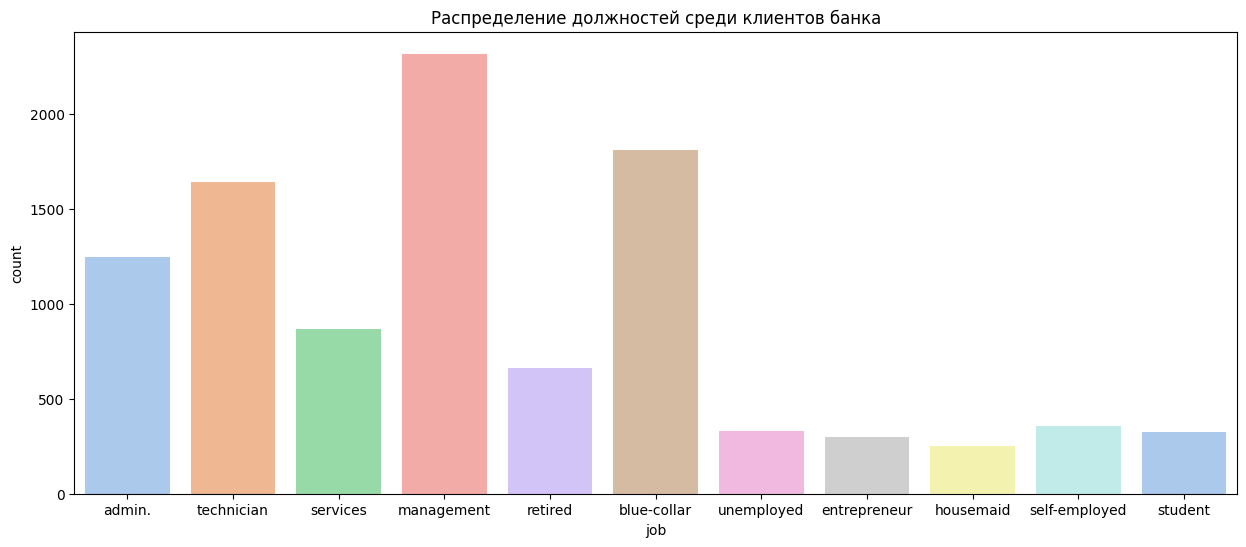

In [283]:
# Построим на распределение должностей среди клиентов
plt.figure(figsize=(15, 6))
job_cnt = sns.countplot(data=cleaned_df, x=cleaned_df['job'], hue='job', palette='pastel')
job_cnt.set_title('Распределение должностей среди клиентов банка');

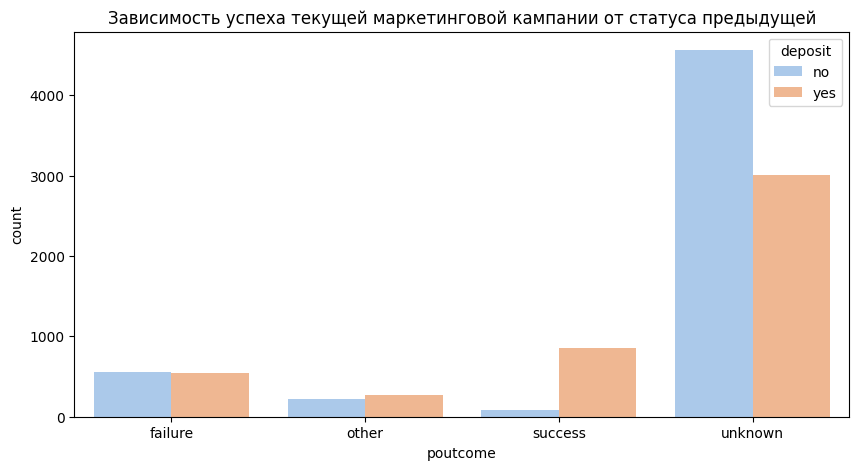

In [284]:
# Узнаем, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач
grouped_ptcm = cleaned_df.groupby('poutcome')['deposit'].value_counts()
# Сбросим индекс для дальнейшей визуализации
df_grouped_ptcm = grouped_ptcm.reset_index()

# Визуализируем с помощью столбчатой диаграммы
fig = plt.figure(figsize=(10, 5))
poutcome_deposit_bar = sns.barplot(data=df_grouped_ptcm, x='poutcome', y='count', hue='deposit', palette='pastel')
poutcome_deposit_bar.set_title('Зависимость успеха текущей маркетинговой кампании от статуса предыдущей');

Большинство клиентов, которые ранее согласились открыть депозит в ходе прошлой маркетинговой кампании, также приняли это предложение в текущей кампании. Это может указывать на высокую лояльность данной группы и их предрасположенность к повторному сотрудничеству с банком.

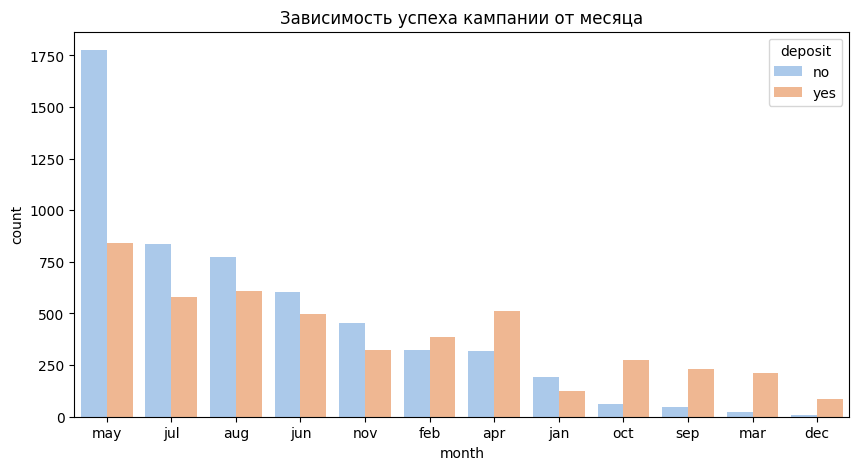

In [285]:
# Узнаем самые успешные месяцы проведения маркетинговых кампаний
grouped_mnth = cleaned_df.groupby('deposit')['month'].value_counts()
# Сбросим индекс для дальнейшей визуализации
df_grouped_mnth = grouped_mnth.reset_index()

# Визуализируем с помощью столбчатой диаграммы
fig = plt.figure(figsize=(10, 5))
month_deposit_bar = sns.barplot(data=df_grouped_mnth, x='month', y='count', hue='deposit', palette='pastel')
month_deposit_bar.set_title('Зависимость успеха кампании от месяца');

На графике видно, что самый большой процент неудач приходится на **май**, стоит пересмотреть решение насчет проведения кампаний в этом месяце. \
Самыми успешными месяцами стоит отметить **сентябрь**, **октябрь**, **декабрь** и **март**, так как на них приходится самый низкий процент неудач. Исходя из этого, стоит сделать вывод, что лучше сделать акцент именно на этих месяцах, повысив активность маркетинговой кампании

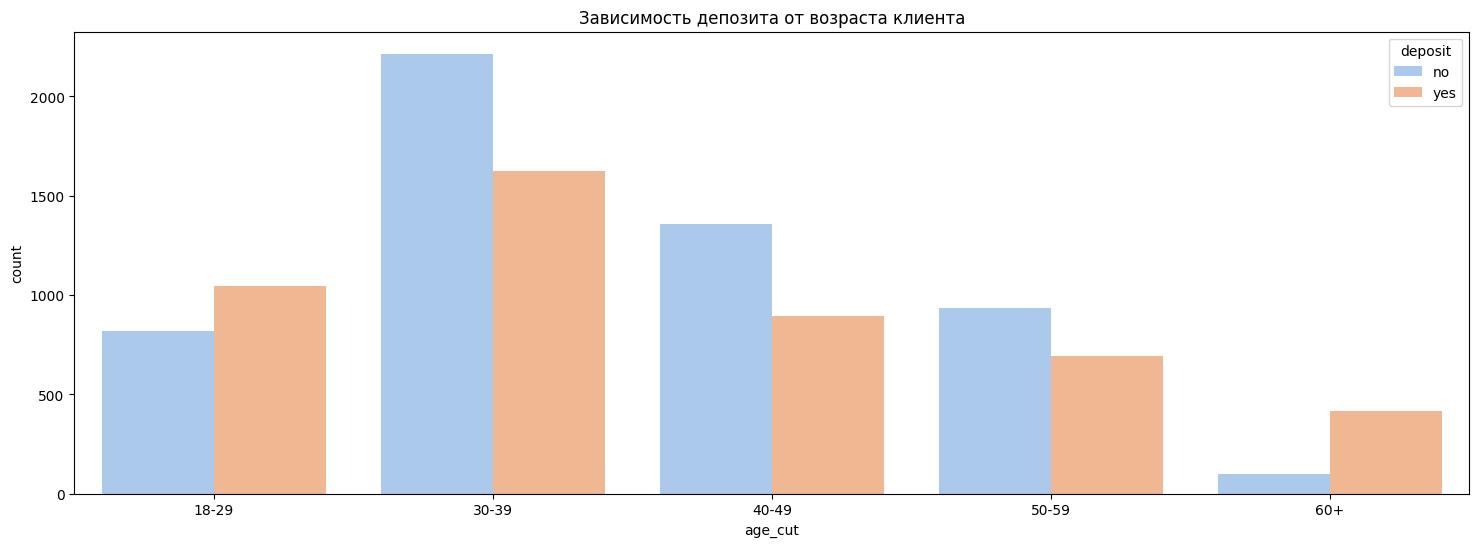

In [286]:
# Разделим возраст на возрастные группы
cleaned_df['age_cut'] = pd.cut(cleaned_df['age'], bins=[18, 30, 40, 50, 60, 95], labels=['18-29', '30-39', '40-49', '50-59', '60+'])

# Определим, в каких группах более склонны открывать депозит
grouped_age = cleaned_df.groupby('deposit')['age_cut'].value_counts()
# Сбросим индекс для дальнейшей визуализации
df_grouped_age = grouped_age.reset_index()

# Визуализируем с помощью столбчатой диаграммы
fig = plt.figure(figsize=(18, 6))
age_deposit_bar = sns.barplot(data=df_grouped_age, x='age_cut', y='count', hue='deposit', palette='pastel')
age_deposit_bar.set_title('Зависимость депозита от возраста клиента');

Исходя из столбчатой диаграммы четко видно, что к открытию вкладов склонны клиенты до 30 и после 60 лет

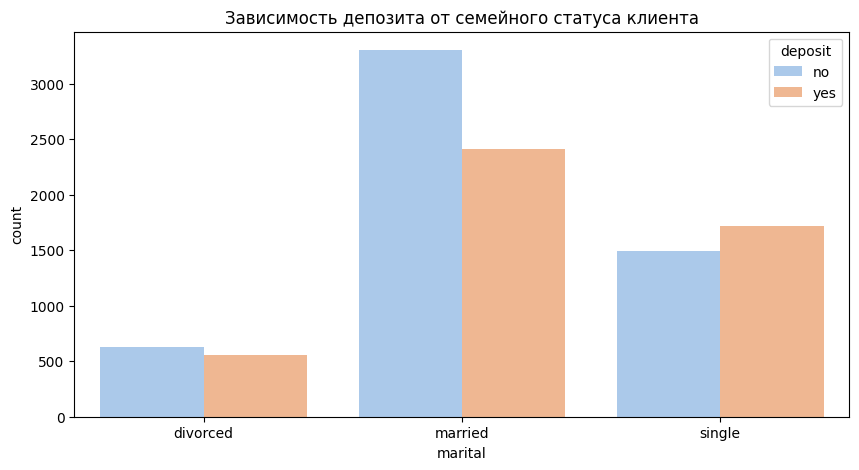

In [287]:
# Узнаем клиентов, открывших депозит в зависимости от семейного статуса
grouped_mrtl = cleaned_df.groupby('marital')['deposit'].value_counts()
# Сбросим индекс для дальнейшей визуализации
df_grouped_mrtl = grouped_mrtl.reset_index()

# Визуализируем с помощью столбчатой диаграммы
fig = plt.figure(figsize=(10, 5))
marital_deposit_bar = sns.barplot(data=df_grouped_mrtl, x='marital', y='count', hue='deposit', palette='pastel')
marital_deposit_bar.set_title('Зависимость депозита от семейного статуса клиента');

Стоит отметить, что к открытию депозита более склонны люди, находящиеся вне брака

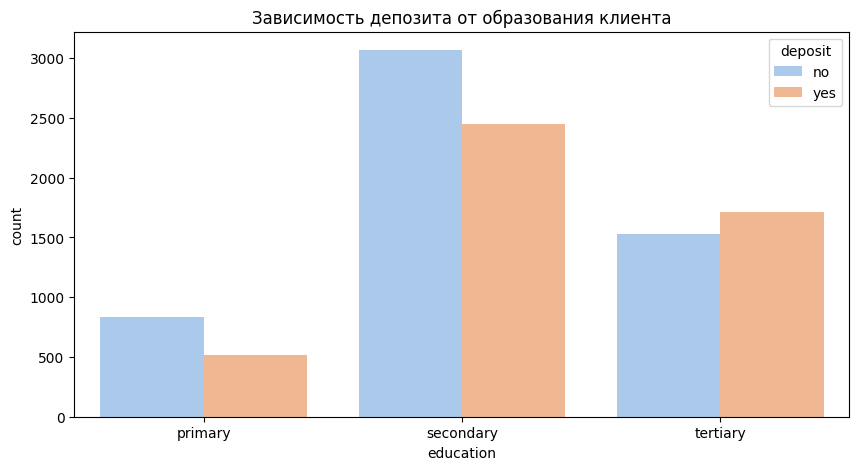

In [288]:
# Узнаем клиентов, открывших депозит в зависимости от образования
grouped_educ = cleaned_df.groupby('education')['deposit'].value_counts()
# Сбросим индекс для дальнейшей визуализации
df_grouped_educ = grouped_educ.reset_index()

# Визуализируем с помощью столбчатой диаграммы
fig = plt.figure(figsize=(10, 5))
educ_deposit_bar = sns.barplot(data=df_grouped_educ, x='education', y='count', hue='deposit', palette='pastel')
educ_deposit_bar.set_title('Зависимость депозита от образования клиента');

Клиенты, имеющие высшее образование, с большей вероятностью согласятся открыть депозит

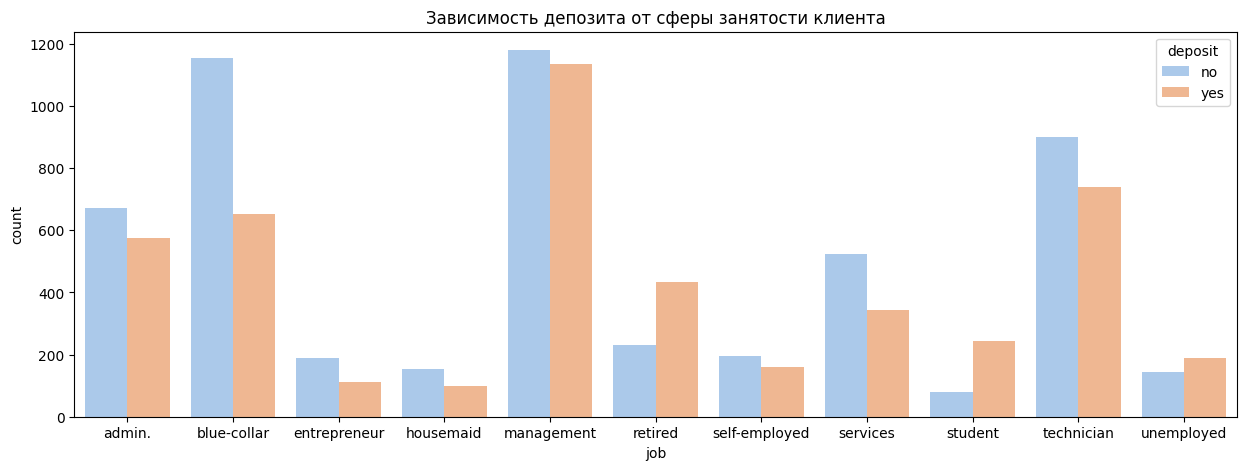

In [289]:
# Узнаем клиентов, открывших депозит в зависимости от вида профессиональной дея-ти
grouped_job = cleaned_df.groupby('job')['deposit'].value_counts()
# Сбросим индекс для дальнейшей визуализации
df_grouped_job = grouped_job.reset_index()

# Визуализируем с помощью столбчатой диаграммы
fig = plt.figure(figsize=(15, 5))
job_deposit_bar = sns.barplot(data=df_grouped_job, x='job', y='count', hue='deposit', palette='pastel')
job_deposit_bar.set_title('Зависимость депозита от сферы занятости клиента');

График показывает, что больше всего клиентов заняты в сфере **менеджмента**, а лучшие показатели по открытию вкладов имеют **студенты**, **пенсионеры**, и **безработные**. Стоит учесть эти категории людей

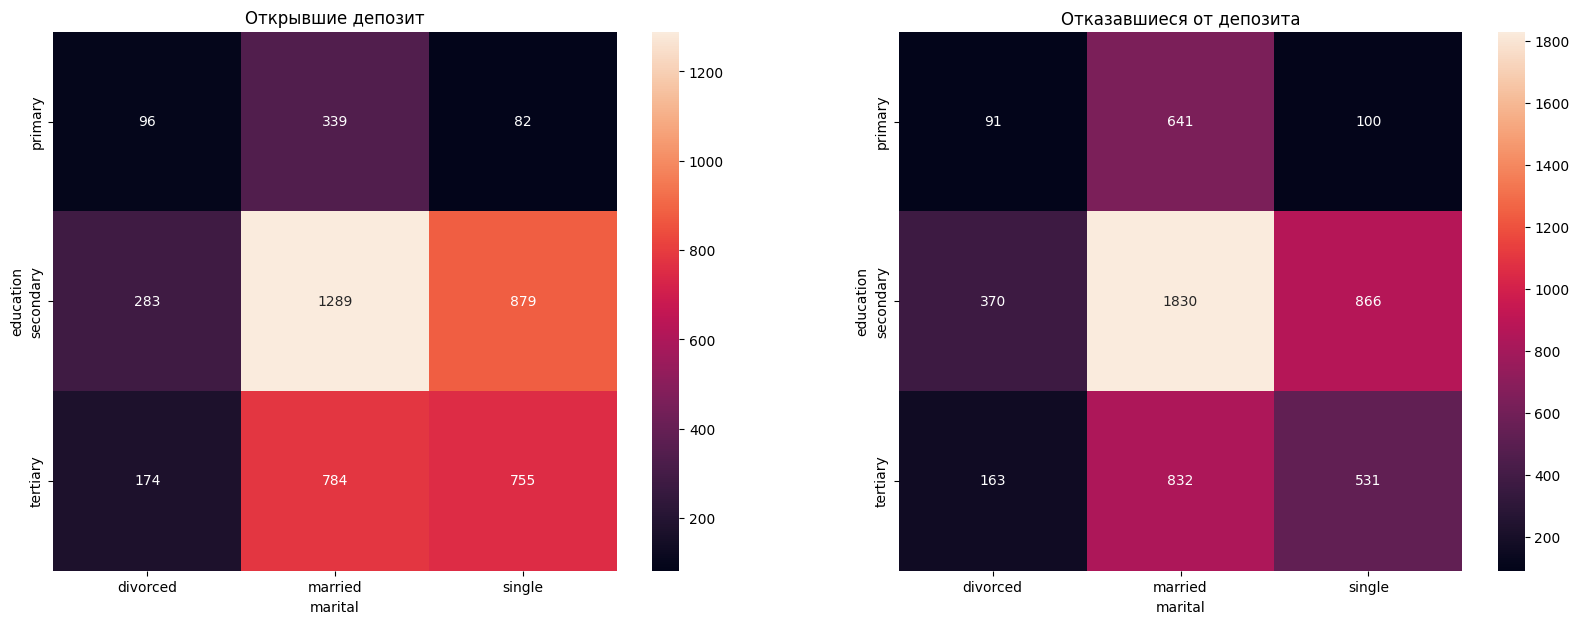

In [290]:
# Отфильтруем DataFrame на открывших депозит и на тех, кто отказался
opened_deposit = cleaned_df[cleaned_df['deposit'] == 'yes']
not_opened_deposit = cleaned_df[cleaned_df['deposit'] == 'no']

# Создадим сводные таблицы по уровню образования и семейному положению
pivot_opened = opened_deposit.pivot_table(values='age', index='education', columns='marital', aggfunc='size')
pivot_not_opened = not_opened_deposit.pivot_table(values='age', index='education', columns='marital', aggfunc='size')

# Визуализируем получившиеся таблицы при промощи тепловых карт
fig, axes = plt.subplots(1, 2, figsize=(20, 7))
heatmap_opened = sns.heatmap(data=pivot_opened, annot=True, fmt='d', ax=axes[0])
heatmap_opened.set_title('Открывшие депозит');
heatmap_not_opened = sns.heatmap(data=pivot_not_opened, annot=True, fmt='d', ax=axes[1])
heatmap_not_opened.set_title('Отказавшиеся от депозита');

На тепловых картах видно, что среди людей, открывших и отказавшихся от депозита, преобладают те, кто имеет среднее образование и находится в браке. Однако клиенты, которые имеют высшее образование и никогда не состояли в браке, с большей вероятностью откроют депозит

## Преобразование данных

In [291]:
# Закодируем столбцы "education" и "age_cut", используя LabelEncoder
encoder_lbl = LabelEncoder()
label_educ = encoder_lbl.fit_transform(cleaned_df['education'])
label_age = encoder_lbl.fit_transform(cleaned_df['age_cut'])

# Заменим оригинальные столбцы на закодированные
cleaned_df['education'] = label_educ
cleaned_df['age_cut'] = label_age

# Преобразуем признаки в бинарные при помощи LabelBinarizer
encoder_bin = preprocessing.LabelBinarizer()

# Заменим оригинальные столбцы на закодированные
cleaned_df['deposit'] = encoder_bin.fit_transform(cleaned_df['deposit'])
cleaned_df['housing'] = encoder_bin.fit_transform(cleaned_df['housing'])
cleaned_df['loan'] = encoder_bin.fit_transform(cleaned_df['loan'])
cleaned_df['default'] = encoder_bin.fit_transform(cleaned_df['default'])

# Закодируем остальные признаки, при помощи get_dummies()
df_dummy = pd.get_dummies(cleaned_df)

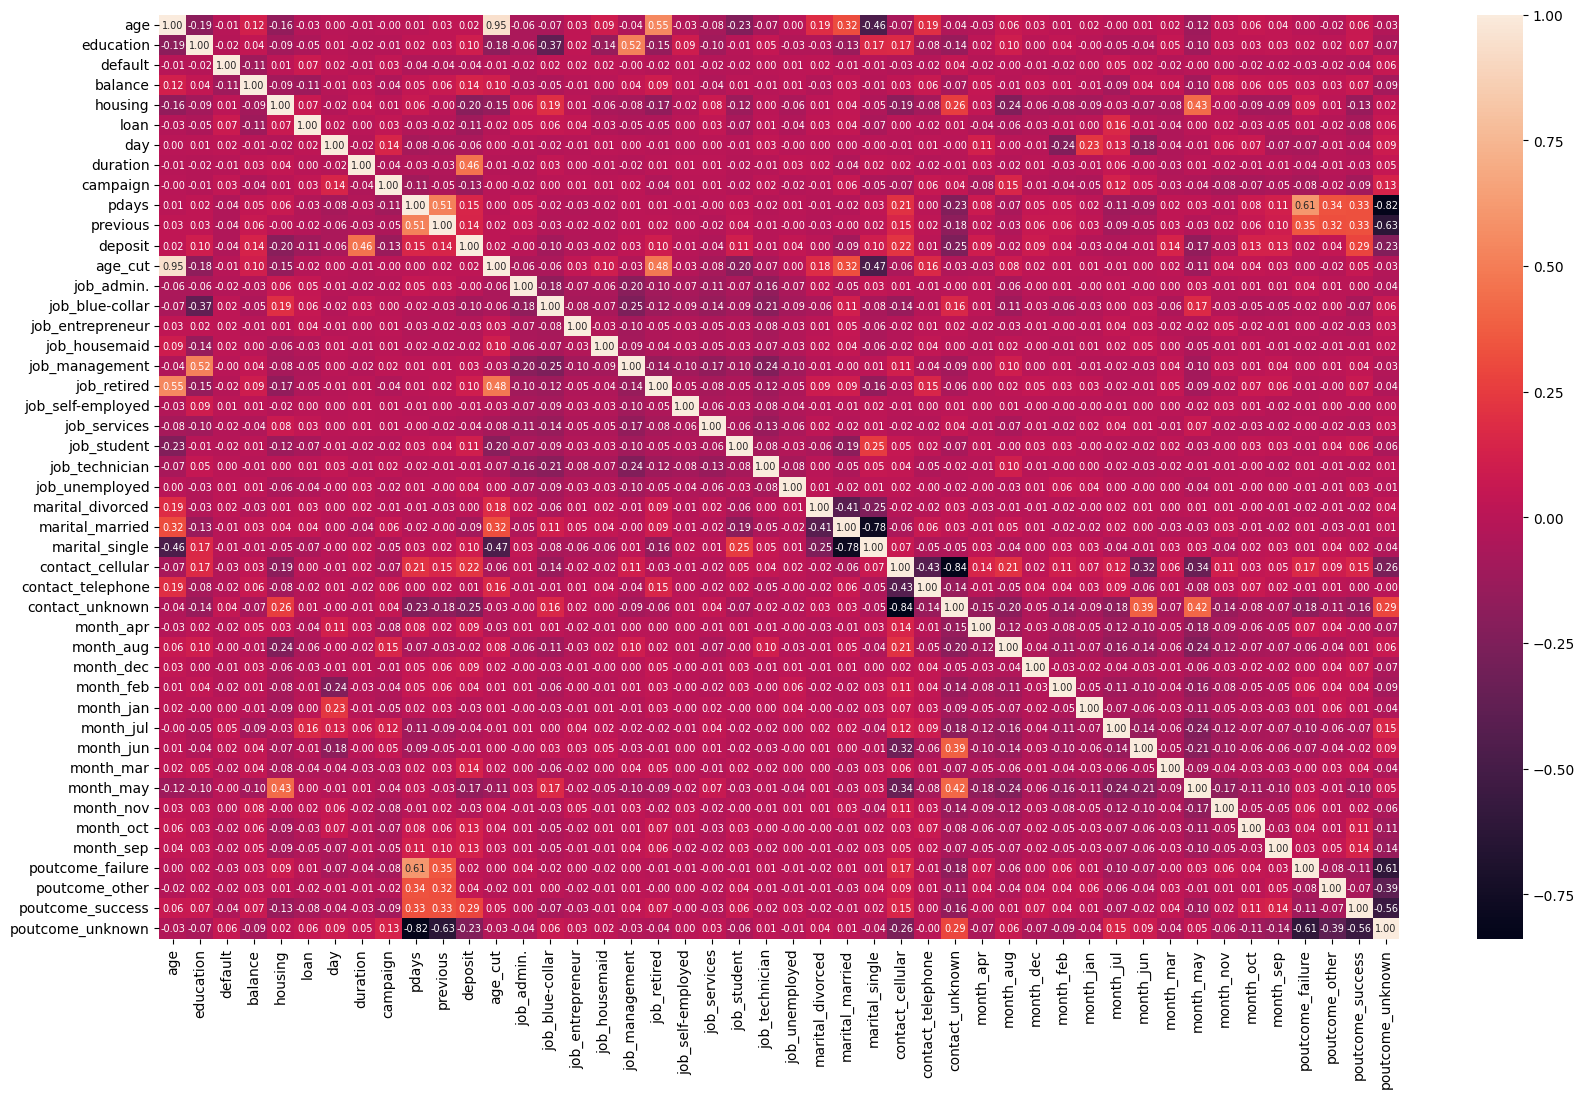

In [292]:
# Построим тепловую карту корреляции
fig = plt.figure(figsize=(20, 12))
corr_map = sns.heatmap(df_dummy.corr(), annot=True, fmt='.2f', annot_kws={'size': 7})

Можем заметить достаточно сильную отрицательную корреляцию между признаками **poutcome_unknown** и **pdays** *(-0.82)*, **contact_cellular** и **contact_unknown** *(-0.84)*, **marital_single** и **marital_married** *(-0.78)*.

Остальные признаки не имеют мультиколлинеарности

In [293]:
X = df_dummy.drop(['deposit'], axis=1) # матрица наблюдений
y = df_dummy['deposit'] # вектор правильных ответов

# Разделяем выборку на тренировочную и тестовую в соотношении 67/33
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42, test_size=0.33)

In [294]:
# C помощью SelectKBest отберем 15 наиболее подходящих признаков
selector = SelectKBest(f_classif, k=15)
selector.fit(X_train, y_train)

# Сохраним признаки в список
selected_features = list(selector.get_feature_names_out())

In [295]:
# Нормализуем данные
mm_scaler = preprocessing.MinMaxScaler() # инициализируем нормализатор MinMaxScaler

# Нормализуем тренировочную выборку
X_train_scaled = mm_scaler.fit_transform(X_train[selected_features])
# Нормализуем тестовую выборку, не обучая повторно
X_test_scaled = mm_scaler.transform(X_test[selected_features])

# Преобразуем нормализованные данные обратно в датафрейм
X_train_scaled = pd.DataFrame(X_train_scaled, columns=selected_features)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=selected_features)

# Построение и обучение модели для предсказания открытия депозита

#### Будем использовать стекинг для достижения наилучшего результата, подобрав для каждой модели оптимальные гиперпараметры при помощи библиотеки Optuna

In [296]:
import optuna

# Определяем функцию для оптимизации гиперпараметров RidgeClassifier с помощью Optuna
def optuna_rc(trial):
    # Задаем пространство поиска гиперпараметров
    alpha = alpha = trial.suggest_uniform('alpha', 0.01, 10) # выбираем alpha в диапазоне [0.01, 10]
    solver = trial.suggest_categorical('solver', ['auto', 'lsqr', 'saga']) # выбираем метод решения
    
    # Создаем модель с заданными параметрами
    model_rc = linear_model.RidgeClassifier(
        alpha=alpha,
        solver=solver,
        max_iter=1000, # максимальное количество итераций
        random_state=42
    )
    
    # Выполняем кросс-валидацию с 15 фолдами и метрикой F1-score
    scores = cross_val_score(model_rc, X_train_scaled, y_train, cv=15, scoring='f1')
    
    # Возвращаем среднее значение F1-score
    return scores.mean()

# Создаем объект исследования Optuna
study_rc = optuna.create_study(study_name='RidgeClassifier', direction='maximize')
# Ищем лучшую комбинацию гиперпараметров n_trials раз
study_rc.optimize(optuna_rc, n_trials=25)

# Получим лучшие параметры
best_params_rc = study_rc.best_params

print(f'Лучшие параметры для Ridge Classifier: {best_params_rc}')
print(f'Лучшее значение F1-Score: {round(study_rc.best_value, 3)}')

[I 2025-02-05 20:49:55,299] A new study created in memory with name: RidgeClassifier
[I 2025-02-05 20:49:55,346] Trial 0 finished with value: 0.7760686687822534 and parameters: {'alpha': 6.048745007928921, 'solver': 'auto'}. Best is trial 0 with value: 0.7760686687822534.
[I 2025-02-05 20:49:55,397] Trial 1 finished with value: 0.7746475237760495 and parameters: {'alpha': 6.454080753081707, 'solver': 'lsqr'}. Best is trial 0 with value: 0.7760686687822534.
[I 2025-02-05 20:49:55,543] Trial 2 finished with value: 0.7749237982992594 and parameters: {'alpha': 6.660380042636244, 'solver': 'saga'}. Best is trial 0 with value: 0.7760686687822534.
[I 2025-02-05 20:49:55,595] Trial 3 finished with value: 0.7789505295908812 and parameters: {'alpha': 1.9925321902273962, 'solver': 'lsqr'}. Best is trial 3 with value: 0.7789505295908812.
[I 2025-02-05 20:49:55,740] Trial 4 finished with value: 0.7758520322040005 and parameters: {'alpha': 6.119406995769822, 'solver': 'saga'}. Best is trial 3 with v

Лучшие параметры для Ridge Classifier: {'alpha': 0.216193913424818, 'solver': 'lsqr'}
Лучшее значение F1-Score: 0.78


In [297]:
# Определяем функцию для оптимизации гиперпараметров RandomForestClassifier
def optuna_rf(trial):
    # Задаем пространство поиска гиперпараметров
    n_estimators = trial.suggest_int('n_estimators', 100, 200, 1) # кол-во деревьев в лесу
    max_depth = trial.suggest_int('max_depth', 10, 30, 1) # максимальная глубина дерева
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1) # минимальное число объектов в листе
    
    # Создаем модель случайного леса
    model_rf = ensemble.RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )
    
    # Выполняем кросс-валидацию
    scores = cross_val_score(model_rf, X_train_scaled, y_train, cv=4, scoring='f1')
    
    return scores.mean()

# Оптимизация гиперпараметров для RandomForestClassifier
study_rf = optuna.create_study(study_name='RandomForestClassifier', direction='maximize')
study_rf.optimize(optuna_rf, n_trials=25)

# Найдем лучшие параметры
best_params_rf = study_rf.best_params

print(f'Лучшие параметры для Random Forest: {best_params_rf}')
print(f'Лучшее значение F1-Score: {round(study_rf.best_value, 3)}')

[I 2025-02-05 20:49:56,978] A new study created in memory with name: RandomForestClassifier
[I 2025-02-05 20:49:57,850] Trial 0 finished with value: 0.819096076747599 and parameters: {'n_estimators': 105, 'max_depth': 30, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.819096076747599.
[I 2025-02-05 20:49:59,555] Trial 1 finished with value: 0.8193234721201998 and parameters: {'n_estimators': 185, 'max_depth': 22, 'min_samples_leaf': 5}. Best is trial 1 with value: 0.8193234721201998.
[I 2025-02-05 20:50:00,488] Trial 2 finished with value: 0.8165646342279508 and parameters: {'n_estimators': 119, 'max_depth': 12, 'min_samples_leaf': 8}. Best is trial 1 with value: 0.8193234721201998.
[I 2025-02-05 20:50:01,568] Trial 3 finished with value: 0.8197503144519318 and parameters: {'n_estimators': 125, 'max_depth': 24, 'min_samples_leaf': 6}. Best is trial 3 with value: 0.8197503144519318.
[I 2025-02-05 20:50:02,849] Trial 4 finished with value: 0.818073674650221 and parameters: {'n_est

Лучшие параметры для Random Forest: {'n_estimators': 145, 'max_depth': 12, 'min_samples_leaf': 3}
Лучшее значение F1-Score: 0.823


In [298]:
# Определяем функцию для оптимизации гиперпараметров GradientBoostingClassifier
def optuna_gb(trial):
    # Задаем пространство поиска гиперпараметров
    learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.2) # темп обучения
    n_estimators = trial.suggest_int('n_estimators', 50, 500, 20) # количество деревьев
    max_depth = trial.suggest_int('max_depth', 7, 30, 1) # глубина дерева
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 15, 1) # минимальный размер листа
    
    # Создаем модель градиентного бустинга
    model_gb = ensemble.GradientBoostingClassifier(
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )
    
    # Выполняем кросс-валидацию
    scores = cross_val_score(model_gb, X_train_scaled, y_train, cv=4, scoring='f1')
    
    return scores.mean()

# Оптимизация гиперпараметров для GradientBoostingClassifier
study_gb = optuna.create_study(study_name='GradientBoostingClassifier', direction='maximize')
study_gb.optimize(optuna_gb, n_trials=20)

# Найдем лучшие параметры
best_params_gb = study_gb.best_params

print(f'Лучшие параметры для Gradient Boosting: {best_params_gb}')
print(f'Лучшее значение F1-Score: {round(study_gb.best_value, 3)}')

[I 2025-02-05 20:50:30,669] A new study created in memory with name: GradientBoostingClassifier
[I 2025-02-05 20:50:48,875] Trial 0 finished with value: 0.7924579798639617 and parameters: {'learning_rate': 0.12455803208444817, 'n_estimators': 270, 'max_depth': 13, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.7924579798639617.
[I 2025-02-05 20:50:59,094] Trial 1 finished with value: 0.7934715345102366 and parameters: {'learning_rate': 0.15267764756160943, 'n_estimators': 270, 'max_depth': 8, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.7934715345102366.
[I 2025-02-05 20:51:15,009] Trial 2 finished with value: 0.7966621454244702 and parameters: {'learning_rate': 0.06780193381020756, 'n_estimators': 150, 'max_depth': 19, 'min_samples_leaf': 3}. Best is trial 2 with value: 0.7966621454244702.
[I 2025-02-05 20:51:37,971] Trial 3 finished with value: 0.8004813166363666 and parameters: {'learning_rate': 0.021138191300509656, 'n_estimators': 390, 'max_depth': 16, 'min_samples

Лучшие параметры для Gradient Boosting: {'learning_rate': 0.015888593896514376, 'n_estimators': 150, 'max_depth': 8, 'min_samples_leaf': 6}
Лучшее значение F1-Score: 0.815


In [299]:
# Определяем функцию для оптимизации гиперпараметров LogisticRegression в стекинге
def optuna_stacking(trial):
    # Задаем пространство поиска гиперпараметров
    C = trial.suggest_loguniform('C', 0.01, 10) # регуляризация
    solver = trial.suggest_categorical('solver', ['lbfgs', 'liblinear', 'saga']) # алгоритм оптимизации

    # Создаем метамодель - логистическая регрессия
    meta_model = linear_model.LogisticRegression(
        C=C,
        solver=solver,
        max_iter=1000,
        random_state=42
    )
    
    # Создаем список кортежей вида: (наименование модели, модель)
    estimators = [
        ('rc', linear_model.RidgeClassifier(**best_params_rc, max_iter=1000, random_state=42)),
        ('rf', ensemble.RandomForestClassifier(**best_params_rf, random_state=42)),
        ('gb', ensemble.GradientBoostingClassifier(**best_params_gb, random_state=42))
    ]
    # Создаем класса стекинг
    stacking_model = ensemble.StackingClassifier(
        estimators=estimators,
        final_estimator=meta_model, # оптимизируемая метамодель
        n_jobs=-1
    )
    
    # Выполняем кросс-валидацию
    scores = cross_val_score(stacking_model, X_train_scaled, y_train, cv=4, scoring='f1')
    
    return scores.mean()

# Оптимизация гиперпараметров для стекинга
study_stacked = optuna.create_study(study_name='LogisticRegression', direction='maximize')
study_stacked.optimize(optuna_stacking, n_trials=20)

# Найдем лучшие параметры
best_params_stacked = study_stacked.best_params

print(f'Лучшие параметры для Logistic Regression: {best_params_stacked}')
print(f'Лучшее значение F1-Score: {round(study_stacked.best_value, 3)}')

[I 2025-02-05 20:54:51,338] A new study created in memory with name: LogisticRegression
[I 2025-02-05 20:55:09,274] Trial 0 finished with value: 0.8145605980601565 and parameters: {'C': 0.09765467277825216, 'solver': 'saga'}. Best is trial 0 with value: 0.8145605980601565.
[I 2025-02-05 20:55:25,034] Trial 1 finished with value: 0.814752778425271 and parameters: {'C': 0.5034211972706761, 'solver': 'liblinear'}. Best is trial 1 with value: 0.814752778425271.
[I 2025-02-05 20:55:41,271] Trial 2 finished with value: 0.8158521611980443 and parameters: {'C': 1.1592328762083999, 'solver': 'saga'}. Best is trial 2 with value: 0.8158521611980443.
[I 2025-02-05 20:56:34,857] Trial 3 finished with value: 0.8159168957361392 and parameters: {'C': 4.480245357053294, 'solver': 'saga'}. Best is trial 3 with value: 0.8159168957361392.
[I 2025-02-05 20:56:50,493] Trial 4 finished with value: 0.8158543230785559 and parameters: {'C': 1.106365737225733, 'solver': 'lbfgs'}. Best is trial 3 with value: 0.81

Лучшие параметры для Logistic Regression: {'C': 6.294577531038775, 'solver': 'saga'}
Лучшее значение F1-Score: 0.816


In [300]:
# Создаем список кортежей вида: (наименование модели, модель)
estimators = [
    ('rc', linear_model.RidgeClassifier(**best_params_rc, max_iter=1000, random_state=42)),
    ('rf', ensemble.RandomForestClassifier(**best_params_rf, random_state=42)),
    ('gb', ensemble.GradientBoostingClassifier(**best_params_gb, random_state=42))
]

# Создаем объект класса стекинг
model_sc = ensemble.StackingClassifier(
    estimators=estimators,
    final_estimator=linear_model.LogisticRegression(**best_params_stacked, max_iter=1000, random_state=42),
    cv=5,
    n_jobs=-1
)

# Обучаем модель
model_sc.fit(X_train_scaled, y_train)

# Сделаем предсказание для тренировочной и тестовой выборок
y_train_pred_sc = model_sc.predict(X_train_scaled)
y_test_pred_sc = model_sc.predict(X_test_scaled)

# Выведем отчеты о метриках
print(f'Для тренировочной выборки:\n{metrics.classification_report(y_train, y_train_pred_sc)}')
print(f'Для тестовой выборки:\n{metrics.classification_report(y_test, y_test_pred_sc)}')

Для тренировочной выборки:
              precision    recall  f1-score   support

           0       0.88      0.86      0.87      3634
           1       0.85      0.87      0.86      3136

    accuracy                           0.87      6770
   macro avg       0.86      0.87      0.86      6770
weighted avg       0.87      0.87      0.87      6770

Для тестовой выборки:
              precision    recall  f1-score   support

           0       0.85      0.83      0.84      1790
           1       0.81      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



Модель демонстрирует хорошие результаты как на тренировочных, так и на тестовых данных, с небольшим снижением метрик на тестовой выборке.

Попробуем улучшить показатели, подобрав оптимальный порог вероятности.

In [301]:
# Получаем вероятности для положительного класса (класс 1) на тестовой и тренировочной выборках
y_train_proba_pred_sc = model_sc.predict_proba(X_train_scaled)[:, 1]
y_test_proba_pred_sc = model_sc.predict_proba(X_test_scaled)[:, 1]
# Для удобства завернём numpy-массив в Pandas Series
y_train_proba_pred_sc = pd.Series(y_train_proba_pred_sc)
y_test_proba_pred_sc = pd.Series(y_test_proba_pred_sc)

# Создадим списки для хранения значений метрик
recall_train_scores = []
precision_train_scores = []
f1_train_scores = []
recall_test_scores = []
precision_test_scores = []
f1_test_scores = []

# Генерируем набор вероятностных порогов в диапазоне от 0.1 до 1 с шагом 0.05
thresholds = np.arange(0.1, 1, 0.05)

# Перебираем пороги
for threshold in thresholds:
    # Клиентов, для которых вероятность > threshold, относим к 1 классу
    # В противном случае - к 0 классу
    y_train_pred_sc = y_train_proba_pred_sc.apply(lambda x: 1 if x > threshold else 0)
    y_test_pred_sc = y_test_proba_pred_sc.apply(lambda x: 1 if x > threshold else 0)
    
    # Считаем метрики для каждого порога и добавляем в списки
    recall_train_scores.append(metrics.recall_score(y_train, y_train_pred_sc))
    precision_train_scores.append(metrics.precision_score(y_train, y_train_pred_sc))
    f1_train_scores.append(metrics.f1_score(y_train, y_train_pred_sc))
    
    recall_test_scores.append(metrics.recall_score(y_test, y_test_pred_sc))
    precision_test_scores.append(metrics.precision_score(y_test, y_test_pred_sc))
    f1_test_scores.append(metrics.f1_score(y_test, y_test_pred_sc))

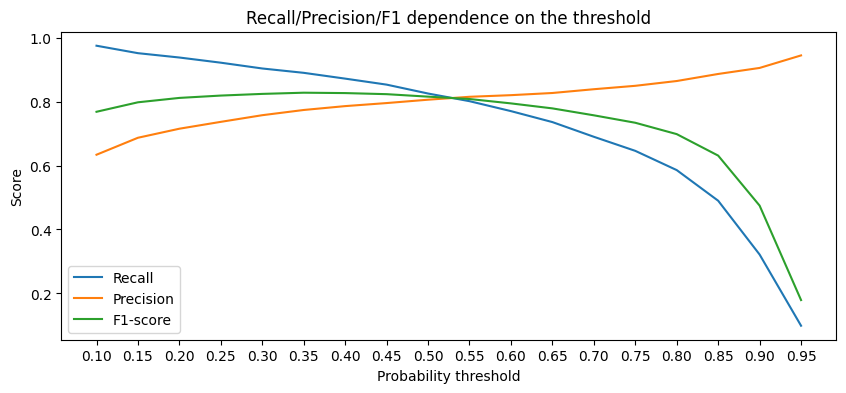

In [304]:
# Визуализируем метрики при различных threshold для тестовой выборки
fig, ax = plt.subplots(figsize=(10, 4))
# Строим линейный график зависимости recall от threshold
ax.plot(thresholds, recall_test_scores, label='Recall')
# Строим линейный график зависимости precision от threshold
ax.plot(thresholds, precision_test_scores, label='Precision')
# Строим линейный график зависимости F1 от threshold
ax.plot(thresholds, f1_test_scores, label='F1-score')

ax.set_title('Recall/Precision/F1 dependence on the threshold')
ax.set_xlabel('Probability threshold')
ax.set_ylabel('Score')
ax.set_xticks(thresholds) 
ax.legend();

Несмотря на то, что значения метрик сходится в значении 0.53, выберем порог 0.43 с наибольшем значением F1-Score, при котором значения presicion и recall сильно не расходятся. 

In [ ]:
# Задаём оптимальный порог вероятностей
threshold_opt = 0.43

# Клиентов, для которых вероятность открытия депозита > 0.43, относим к классу 1
# В противном случае — к классу 0
y_train_pred_opt = y_train_proba_pred_sc.apply(lambda x: 1 if x > threshold_opt else 0)
y_test_pred_opt = y_test_proba_pred_sc.apply(lambda x: 1 if x > threshold_opt else 0)

# Считаем метрики
print(f'Для тренировочной выборки:\n{metrics.classification_report(y_train, y_train_pred_opt)}')
print(f'Для тестовой выборки:\n{metrics.classification_report(y_test, y_test_pred_opt)}')

Для тренировочной выборки:
              precision    recall  f1-score   support

           0       0.90      0.83      0.86      3634
           1       0.82      0.89      0.85      3136

    accuracy                           0.86      6770
   macro avg       0.86      0.86      0.86      6770
weighted avg       0.86      0.86      0.86      6770

Для тестовой выборки:
              precision    recall  f1-score   support

           0       0.87      0.80      0.84      1790
           1       0.79      0.86      0.83      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



Изменение порога помогло немного уменьшить переобучение, что проявляется в улучшении F1-score на тестовой выборке и снижении точности на тренировочной выборке. Это указывает на то, что модель стала менее переобученной и лучше обобщает на новых данных.

# Вывод

В рамках проекта было проведено исследование данных, их предобработка и обучение моделей для предсказания вероятности открытия клиентом банковского депозита. В процессе работы применялись современные методы машинного обучения для улучшения точности и устойчивости модели.

### Ключевые этапы работы:

1. **Анализ данных**  
   - Проведён исследовательский анализ данных, выявлены пропущенные значения и преобразованы категориальные признаки.

2. **Отбор признаков**  
   - Использован метод **SelectKBest** для выбора значимых переменных.

3. **Обучение моделей**  
   - Настройка гиперпараметров для **Ridge Classifier**, **Random Forest** и **Gradient Boosting** с помощью **Optuna**.
   - Применён метод **стекинга (StackingClassifier)** для объединения предсказаний нескольких моделей.

4. **Оценка качества**  
   - **F1-score** на тестовой выборке составил **0.83**, что подтверждает способность модели различать классы.
   - **Стекинг** улучшил качество предсказаний по сравнению с отдельными моделями.
   - **Optuna** позволил добиться ощутимого прироста точности.
   - **Порог вероятности** смог незначительно снизить переобучение